# Harmonic Chain


# 1. Training & Loading

To contine the analysis below, you will have to train the neuralCT mode on Harmonic Chain. This can be done by the line of command:
```
python ./variationMain.py -source 1
```
Also, we have a trained model saving in the **demo** folder. So, in the following, we're going to assume using this saving. However, you can change this by change the **rootFolder** variable.

The loading process is just like we did in the Ring2D example.

In [1]:
import numpy as np
import torch
from torch import nn
import flow
import source
import train
import utils
import math
import h5py

# Set gobal variables.

rootFolder = "./demo/variationModel_source_1_Shift_False_T_300_depthLevel_1_l8_M2_H128/"
device = torch.device("cpu")
dtype = torch.float

# Load paremeters.

with h5py.File(rootFolder+"/parameter.hdf5","r") as f:
    numFlow = int(np.array(f["numFlow"]))
    lossPlotStep = int(np.array(f["lossPlotStep"]))
    hidden = int(np.array(f["hidden"]))
    nlayers = int(np.array(f["nlayers"]))
    nmlp = int(np.array(f["nmlp"]))
    lr = int(np.array(f["lr"]))
    batchSize = int(np.array(f["batchSize"]))
    epochs = int(np.array(f["epochs"]))
    K = int(np.array(f["K"]))

# Build the target.

target = source.HarmonicChain(32,1).to(device).to(dtype)
n = target.nvars[0]//2

# Rebuild the model.

def innerBuilder(num):
    maskList = []
    for i in range(nlayers):
        if i %2==0:
            b = torch.zeros(num)
            i = torch.randperm(b.numel()).narrow(0, 0, b.numel() // 2)
            b.zero_()[i] = 1
            b=b.reshape(1,num)
        else:
            b = 1-b
        maskList.append(b)
    maskList = torch.cat(maskList,0).to(torch.float32)
    fl = flow.RNVP(maskList, [utils.SimpleMLPreshape([num]+[hidden]*nmlp+[num],[nn.Softplus()]*nmlp+[None]) for _ in range(nlayers)], [utils.SimpleMLPreshape([num]+[hidden]*nmlp+[num],[nn.Softplus()]*nmlp+[utils.ScalableTanh(num)]) for _ in range(nlayers)])
    return fl
from utils import flowBuilder
f = flowBuilder(n,numFlow,innerBuilder,1).to(device).to(dtype)

# Load saving.

import os
import glob
name = max(glob.iglob(rootFolder+"savings/"+'*.saving'), key=os.path.getctime)
print("load saving at "+name)
saved = torch.load(name,map_location=device)
f.load(saved)

/Users/lili/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


load saving at ./demo/variationModel_source_1_Shift_False_T_300_depthLevel_1_l8_M2_H128/savings/FlowNetSaving_epoch4990.saving


OrderedDict([('prior.K', tensor(1.)),
             ('prior.sigma', tensor([1.])),
             ('layerList.0.elements',
              tensor([-5.5568e-01,  1.7802e-01, -4.2235e-01, -5.6941e-01,  1.2364e+00,
                      -5.8761e-01, -1.3454e-01, -6.2320e-01,  4.8339e-01, -4.8890e-01,
                       5.2813e-01, -6.2553e-01, -2.9184e-01, -3.8397e-01, -6.1544e-01,
                       2.2584e+00,  1.1487e-01, -6.2343e-01, -4.0372e-02, -6.0327e-01,
                       9.5033e-01, -5.7191e-01, -4.4469e-01, -3.1179e-01, -6.3217e-01,
                       1.5985e+00, -4.9294e-01,  6.8453e-01, -6.1621e-01, -2.0854e-01,
                      -5.9571e-01,  2.3138e-01,  4.1520e-42, -1.2679e-41, -4.6694e-41,
                       6.4642e-42, -1.1444e-41,  5.1007e-43, -1.6380e-41, -5.8448e-42,
                       6.5805e-42, -5.3474e-42, -1.1512e-41,  1.7361e-41,  3.7415e-42,
                      -3.2650e-42, -3.1633e-41,  3.0352e-42, -3.9741e-42,  2.0400e-41,
          

# 3. Analysis


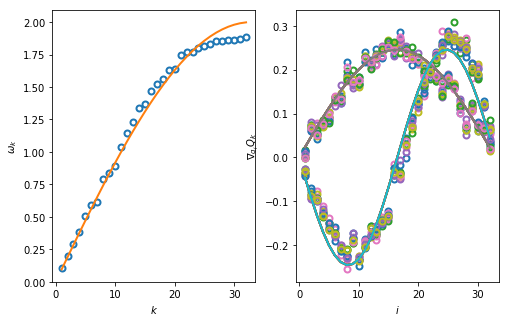

In [2]:
# Calculate modes in the latent space.

d0 = f.layerList[0].elements[:n]
d1 = f.layerList[0].elements[n:]
omega = (1/(torch.exp(d0+d1)))

# Plot these modes against analytic result.

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 5))

plt.subplot(121)
omega, idx = torch.sort(omega)

klist = np.arange(len(omega)) +1

omegalist = 2*np.sin(klist*np.pi/(2*len(omega)+2))

plt.plot(klist, omega.detach().cpu().numpy(), 'o',  markerfacecolor='none', markeredgewidth=2)
plt.plot(klist, omegalist, lw=2, label='analytical')
plt.xlabel('$k$')
plt.ylabel('$\omega_k$')

plt.subplot(122)

batch_size = 10
dim = n*2
x,_ = f.sample(batch_size)
z,_ = f.layerList[1].forward(x)

from utils import jacobian
jaco = jacobian(z,x)

j = np.arange(dim//2)+1

data = jaco.detach().numpy()#
sign = [1, -1]
for batch in range(batch_size):
    for n, i in enumerate(idx[:2]):#
        plt.plot(j, data[batch, i, :dim//2], 'o', label='$k=%g$'%(n+1), markerfacecolor='none', markeredgewidth=2)#
        plt.plot(j, sign[n]*np.sqrt(2/(dim//2+1))*np.sin(j*(n+1)*np.pi/(dim//2+1)), '-', lw=2)

plt.xlabel('$i$')
plt.ylabel(r'$\nabla_{q_i} Q_k$')
plt.show()
